# Lab 6 - Network Optimization Models - The Minimum Spanning Tree Problem

<b>Information on group members:</b><br>
1) 150284, Sofya Aksenyuk; <br>
2) 150281, Uladzimir Ivashka

In [1]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt
import numpy as np
from math import radians, degrees, sin, cos, asin, acos, sqrt
from geopy.distance import geodesic
from colour import Color

1.1) Get acquainted with the below "City" class definition. It has three major fields: name, city's longitude, and latitude. The coordinate's input is in the format "00°00'E/N," and it is converted to a list [degrees, minutes]. Also, these coordinates are also simply converted and stored as x and y coordinates. 

In [2]:
class City:
    def __init__(self, name, long, lat):
        self.name = name
        self.long = [float(long.split("°")[0]), float(long.split("°")[1].replace("'",'').replace("E",''))]
        self.x = self.long[0]*60 + self.long[1]
        self.lat = [float(lat.split("°")[0]), float(lat.split("°")[1].replace("'",'').replace("N",''))]  
        self.y = self.lat[0]*60 + self.lat[1]
       
    def __repr__(self):
        return str(self.name) + " " + str(self.lat) + " " + str(self.long)

1.2) The below piece of code loads cities data from the cities.csv file and creates a list of cities. 

In [3]:
cities = []

with open('cities.csv', newline='', encoding="utf-8") as csvfile:
    r = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in r:
        cities.append(City(row[0], row[1], row[2]))
        
for c in cities[:10]: ### TEST
    print(c)

﻿Adamów (siedleckie) [51.0, 45.0] [22.0, 15.0]
Adamów (zamojskie) [50.0, 36.0] [23.0, 10.0]
Adamówka [50.0, 16.0] [22.0, 42.0]
Aleksandrów [51.0, 16.0] [19.0, 59.0]
Aleksandrów Kujawski [52.0, 53.0] [18.0, 42.0]
Aleksandrów Łódzki [51.0, 49.0] [19.0, 19.0]
Alwernia [50.0, 4.0] [19.0, 32.0]
Andrespol [51.0, 44.0] [19.0, 37.0]
Andrychów [49.0, 52.0] [19.0, 20.0]
Andrzejewo [52.0, 50.0] [22.0, 12.0]


1.3) The function below plots all cities according to their X and Y coordinates. Note that there are so many cities that Poland's boundaries can be observed. Feel free to modify the code. The unrequired input "edges" is a list of pairs of indices indicating edges to be drawn. 

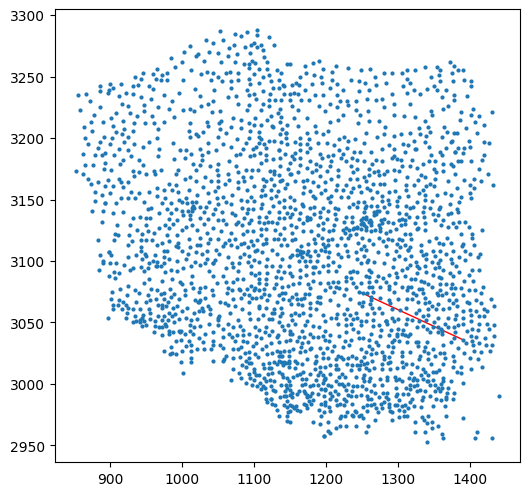

In [4]:
def plotMap(cities, edges=[], no_steps=10, size=(6,6), pointsize=2, lineweight=1):
    fig=plt.figure(figsize=size, dpi= 100, facecolor='w', edgecolor='r')
    colors = list(Color("red").range_to(Color("green"), len(cities)//no_steps + 2))
    
    step = 0
    color = 0
    for i, e in enumerate(edges):
        X = [cities[e[0]].x, cities[e[1]].x]
        Y = [cities[e[0]].y, cities[e[1]].y]
        plt.plot(X, Y, lw=lineweight, ls="-", marker="", color=str(colors[color]))
        step += 1
        
        if step >= 10:
            color += 1
            step = 0
        
    X = [c.x for c in cities]
    Y = [c.y for c in cities]
    plt.plot(X, Y, ms=pointsize, ls="", marker="o")
    
    plt.show()

plotMap(cities, edges=[[1,200]])

1.3) The dataset consists of 2249 cities. It may be too much when it comes to implementing the algorithm for constructing the minimum spanning tree (computational burden). Therefore, you can consider only every n-th row from the dataset to ensure that the computations will be completed in a reasonable time. 

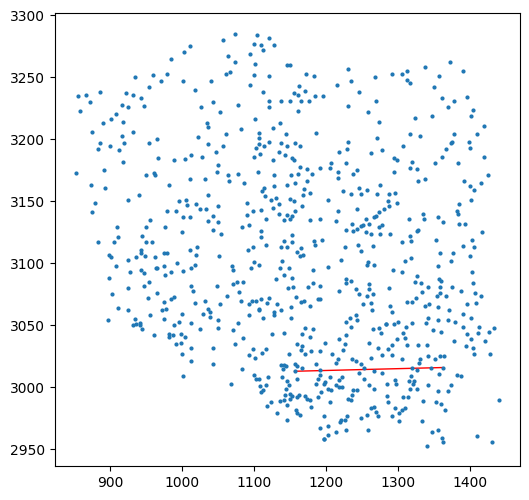

In [5]:
n = 3
cities_small = cities[2::n]
plotMap(cities_small, edges=[[0,200]])

1.4) Finish the function below for constructing a distance matrix. Each i-th row should contain distances from the i-th city to other cities. For convenience and to improve the algorithm's computational complexity for constructing the spanning tree, it is suggested to keep rows sorted according to distance. Rows may contain information on the j-th indices of the respective destinations along with the distances in a tuple (j-th indice, distance). 

You can use the Euclidean distance for computations. You can use the x and .y fields that store the geographical coordinates. This way of formulating a distance does not have much sense because the computation would be based on angles. Nonetheless, it is allowed in this exercise to do so, but if you wish, you can calculate the distances correctly by computing arc lengths between two points on a sphere - Earth. 

In [6]:
def getDistance(lon1, lat1, lon2, lat2):
    if lon1 == lon2 and lat1 == lat2:
        return 0.0

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    return geodesic((lon1, lat1), (lon2, lat2))


def getSortedDistances(cities):
    D = []
    
    for idx1, city1 in enumerate(cities):
        dist = []
        for idx2, city2 in enumerate(cities):
            dist.append( (idx2, getDistance(city1.x, city1.y, city2.x, city2.y)) )
        D.append(sorted(dist, key=lambda x: x[1]))
        
    return D


D = getSortedDistances(cities_small)
print(D[0][:5])

[(0, 0.0), (550, Distance(13.137388402034304)), (287, Distance(16.46930319224684)), (27, Distance(17.784321802345705)), (474, Distance(22.998771836690207))]


1.5) Auxiliary function for finding a corresponding index in the data set for a provided city name. 

In [7]:
def getIdx(name, cities):
    for i, c in enumerate(cities):
        if name == c.name: 
            return i
        
    return None

print(getIdx("Hel", cities_small))

178


1.6) Complete the below greedy algorithm for constructing the minimum spanning tree. As an input, it should return a list of edges of the constructed subgraph, which can then be used in the plotMap function to show the tree structure. You can set the city of Hel as an initial node. 

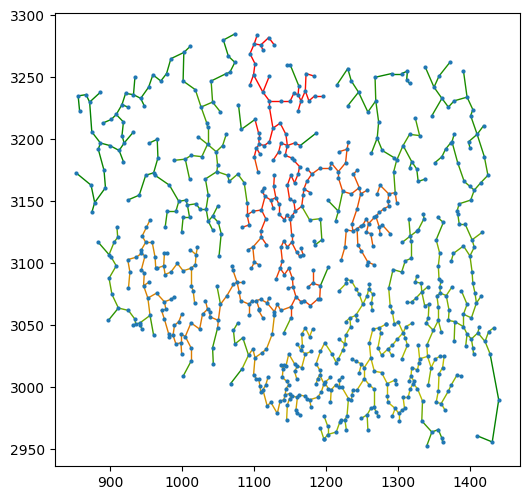

In [8]:
def getSpanningTree(stratingNode, cities, D):
    N = len(cities) 
    edges = []
    IN_TREE = set()
    d = {getIdx(city.name, cities_small): [None, 99999] for city in cities}   # { city: [from city, min_distance] }
    d[stratingNode] = [stratingNode, 0]
    closest_node = sorted(d, key=lambda x: d[x][1])[0]
    
    while len(IN_TREE) < N:
        IN_TREE.add(closest_node)
        edges.append([closest_node, d[closest_node][0]])
        
        for col in D[closest_node]:
            if col[1] < d[col[0]][1]:
                d[col[0]] = [closest_node, col[1]]
        
        for city in sorted(d, key=lambda x: d[x][1]):
            if city not in IN_TREE:
                closest_node = city
                break
    return edges

edges = getSpanningTree(getIdx("Hel", cities_small), cities_small, D)
plotMap(cities_small, edges=edges)

1.6) Modify the code so that it displays the results after 10 intermediate steps. In this way, you can get a better insight into how the algorithm constructs the spanning tree. Additionally, you can use, e.g., a gradient to distinguish between different iterations of the algorithm when plotting the map (e.g., 1-st iteration = 100% red, last iteration == 100% green). 

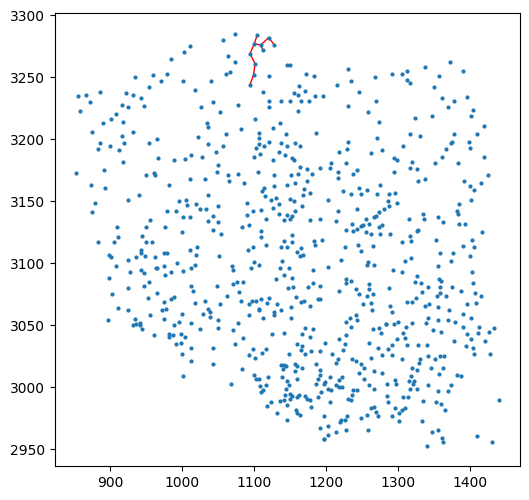

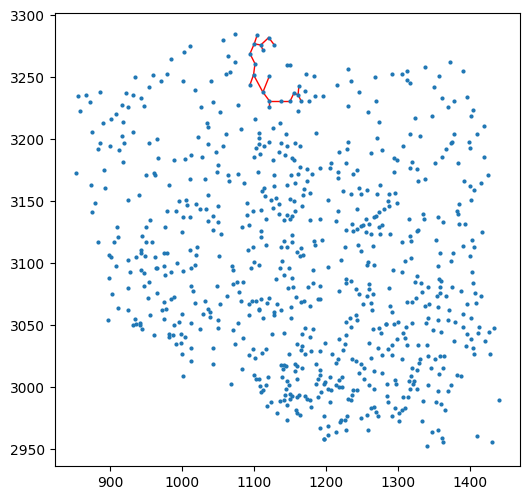

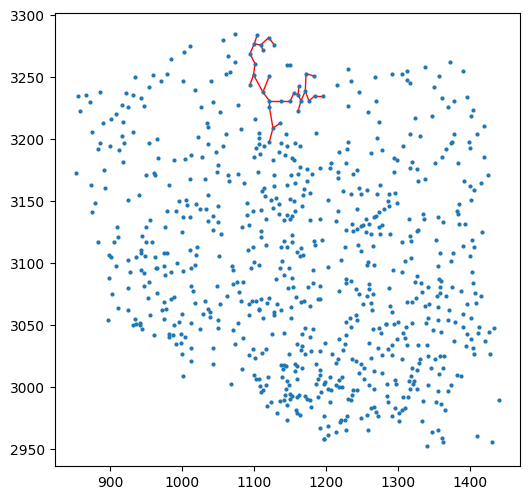

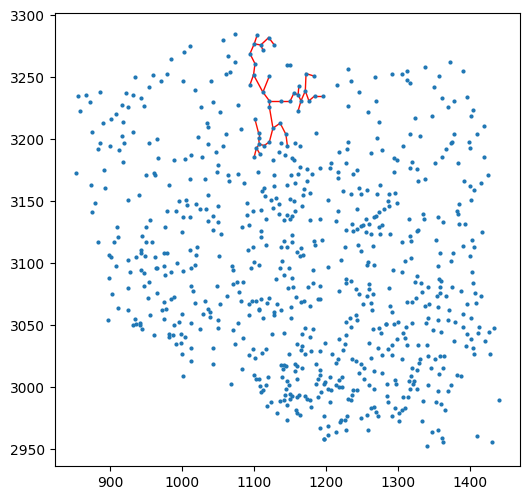

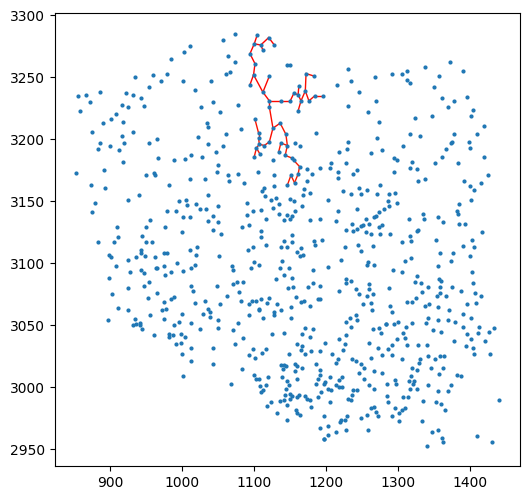

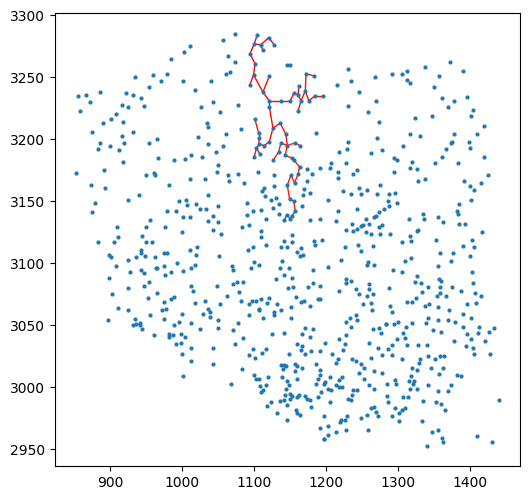

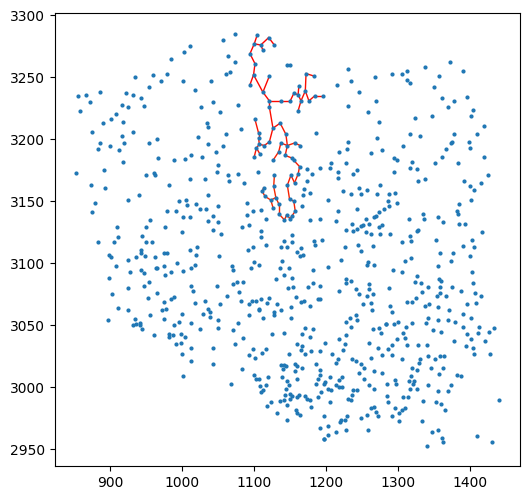

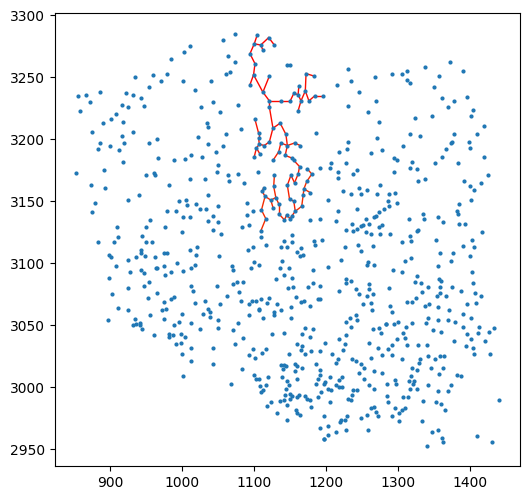

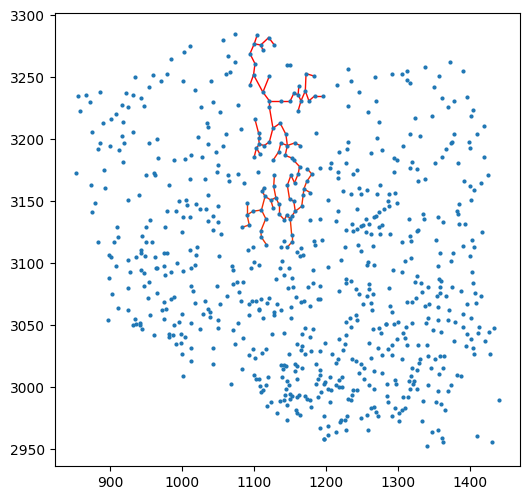

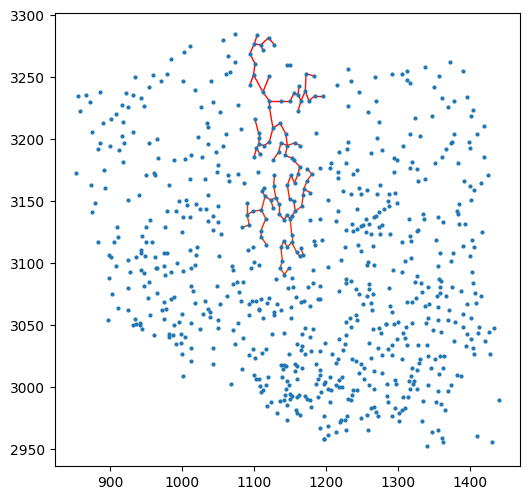

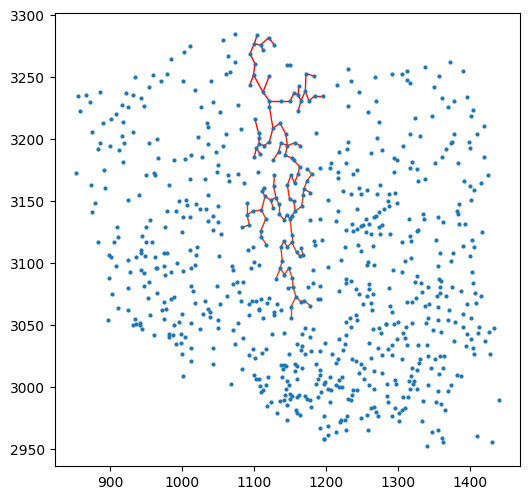

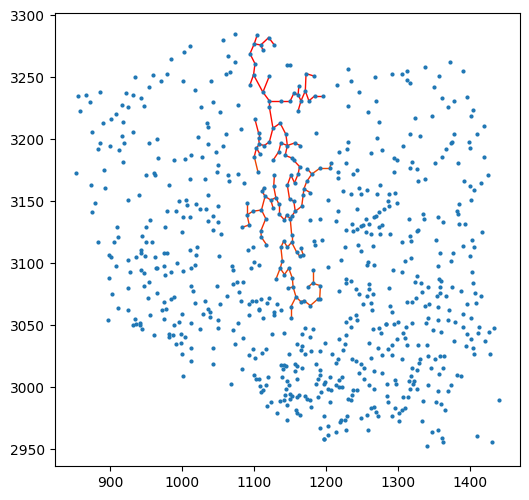

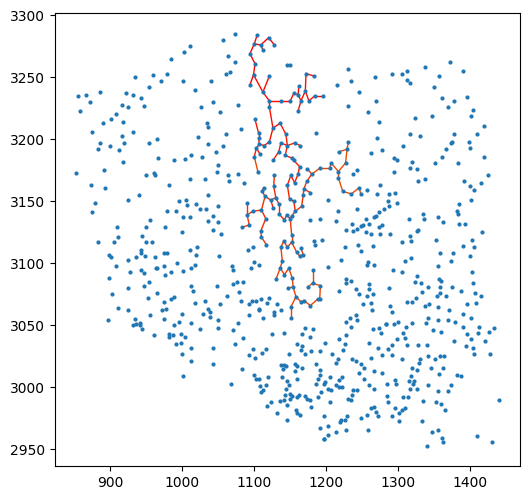

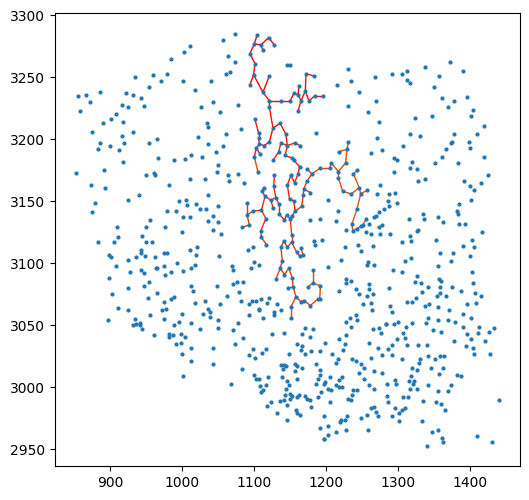

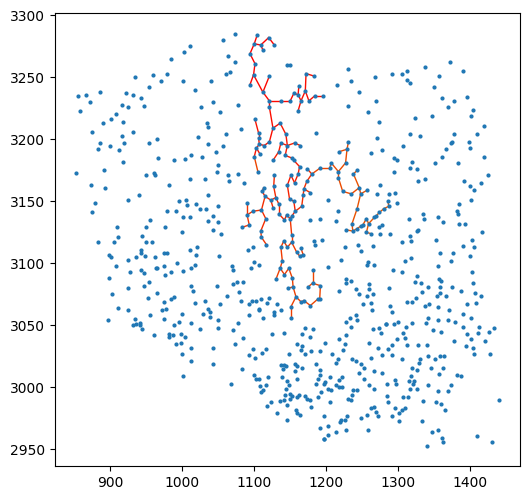

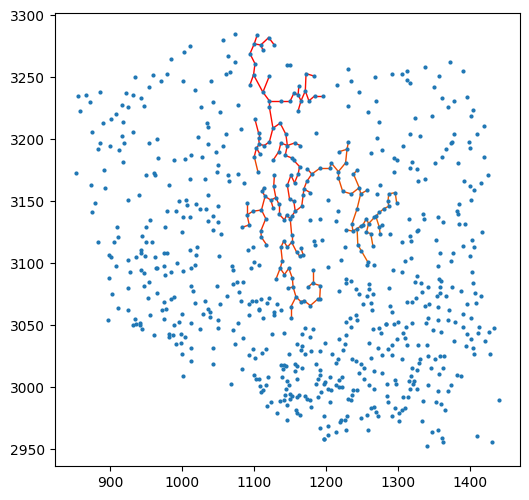

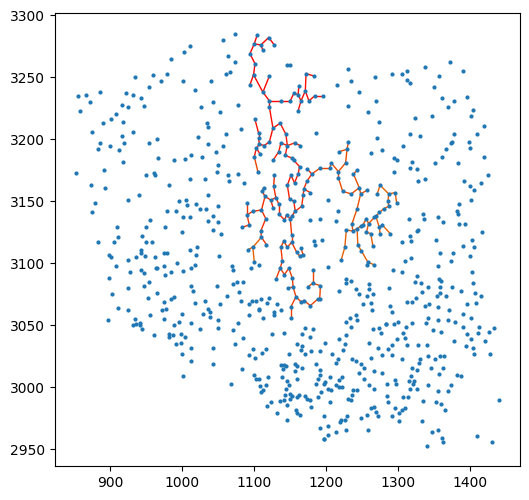

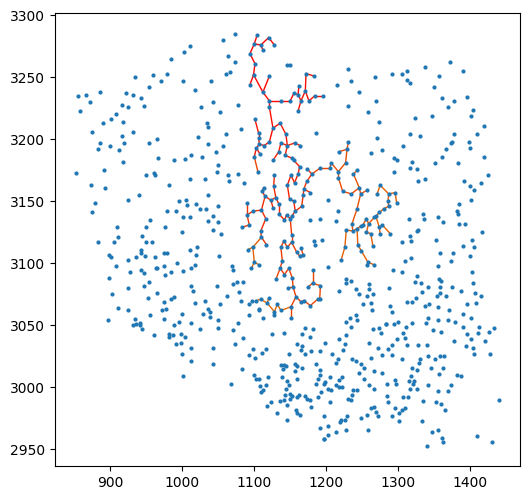

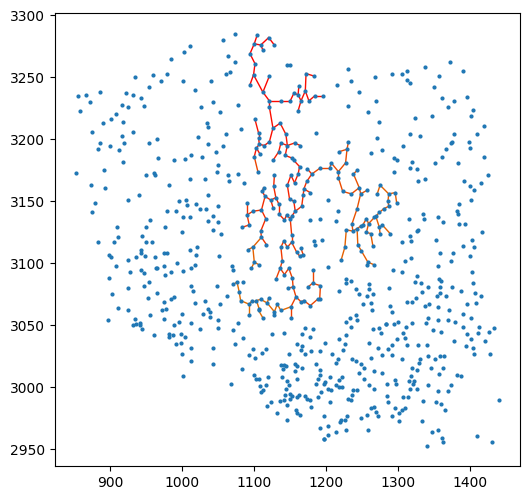

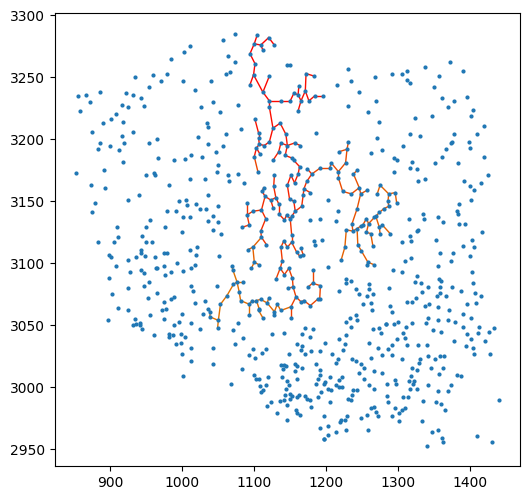

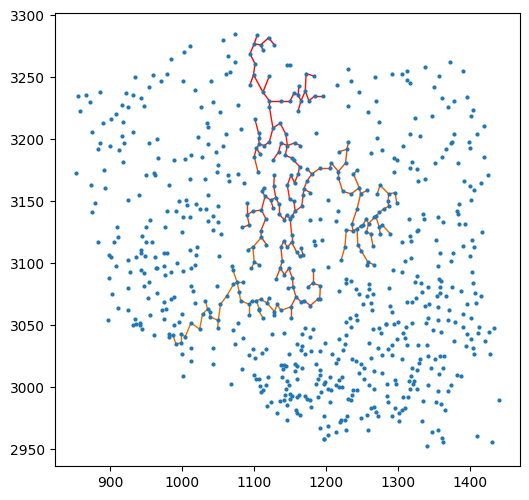

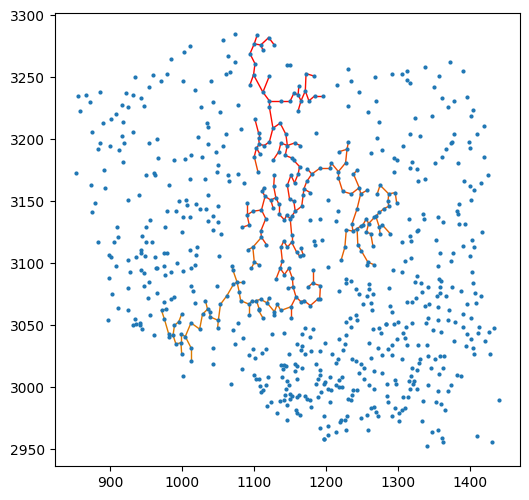

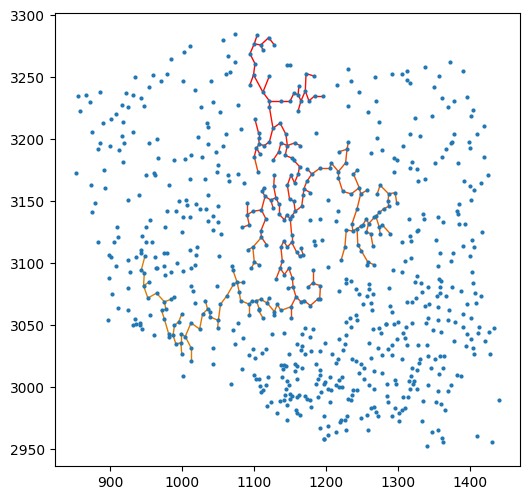

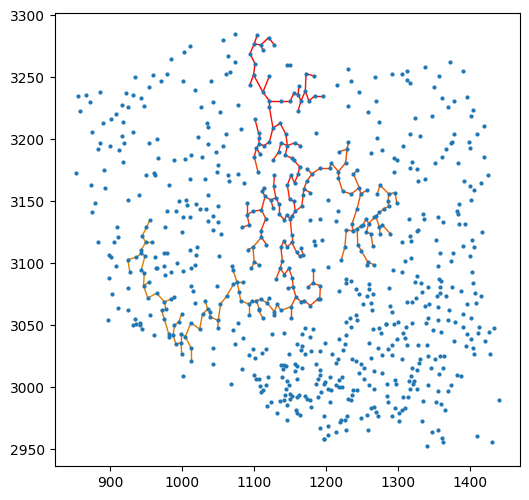

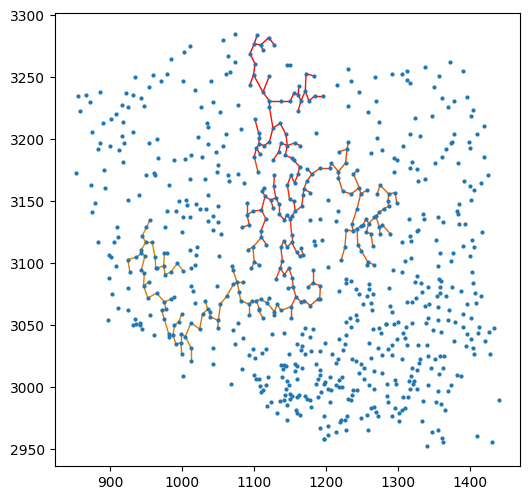

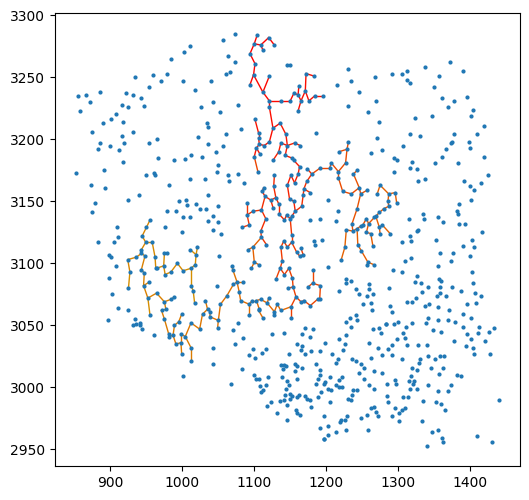

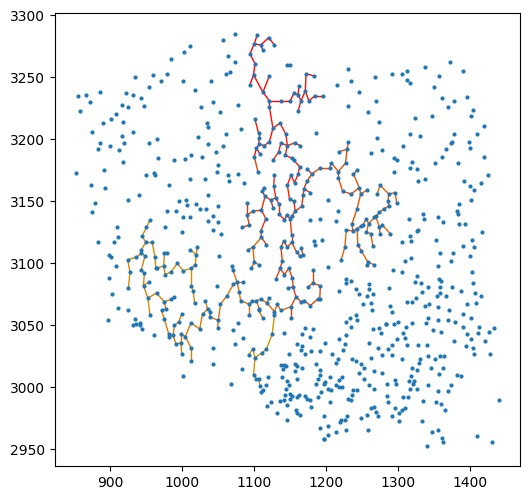

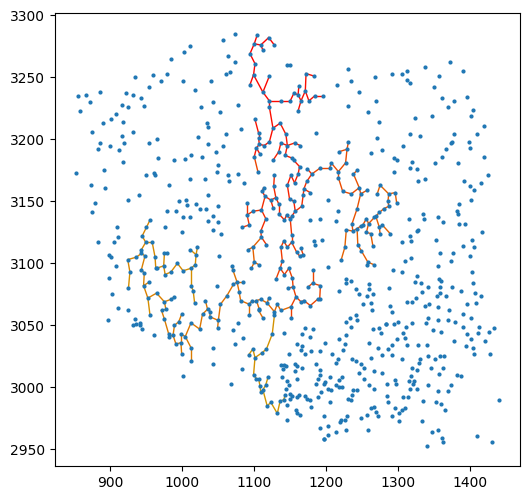

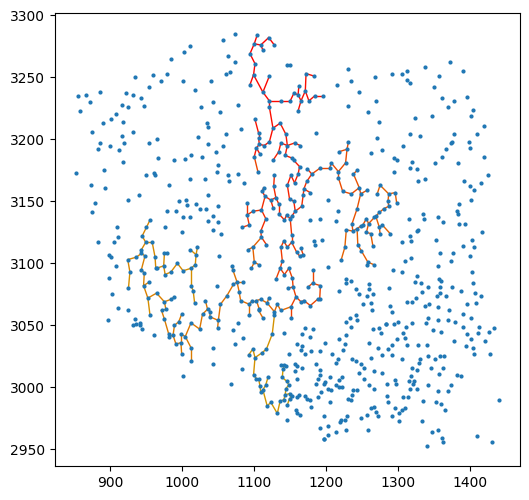

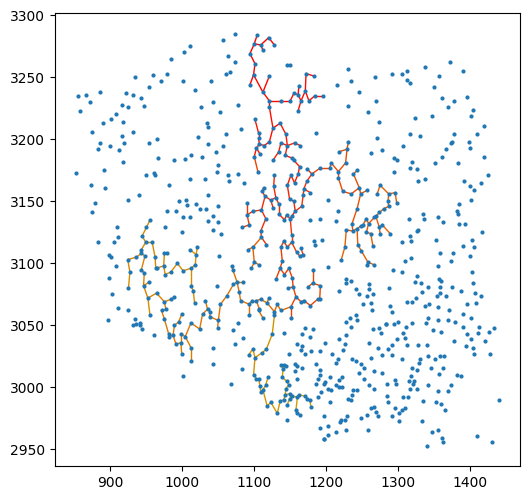

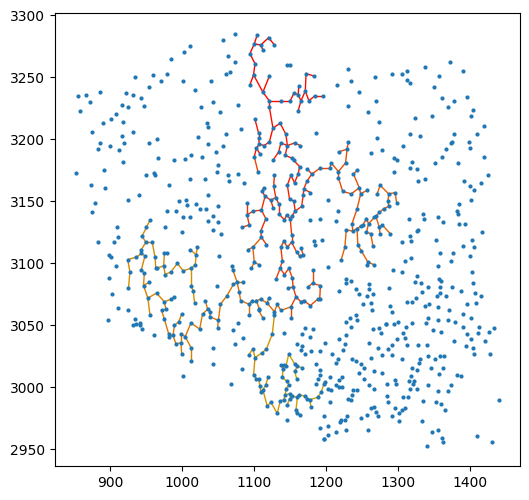

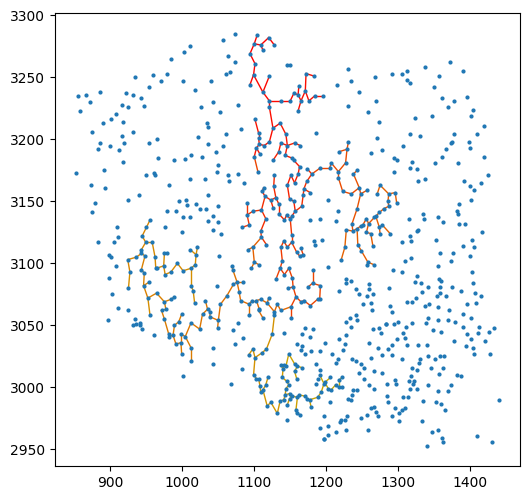

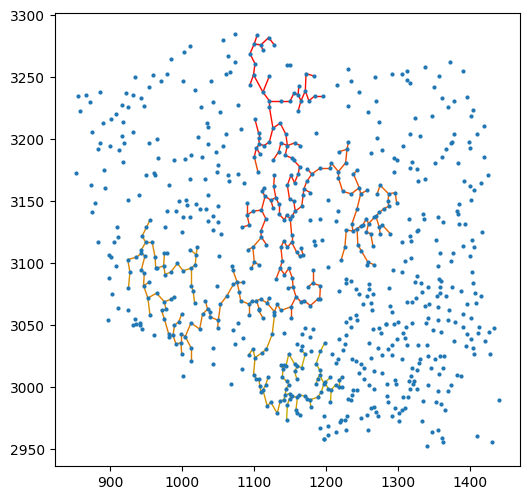

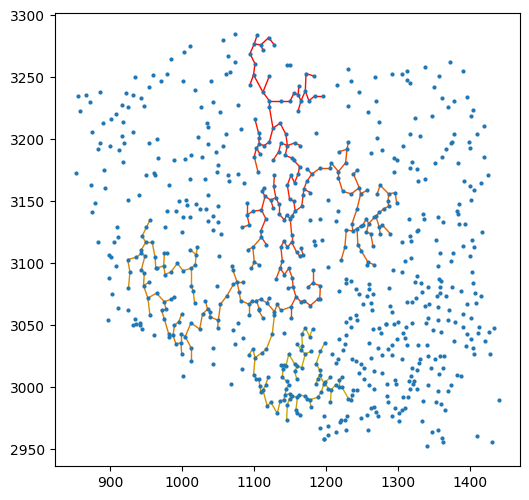

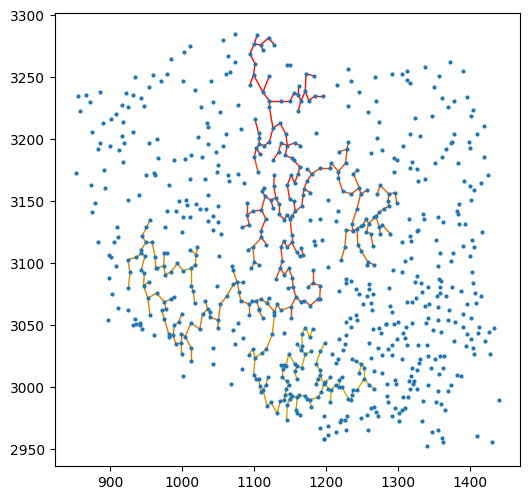

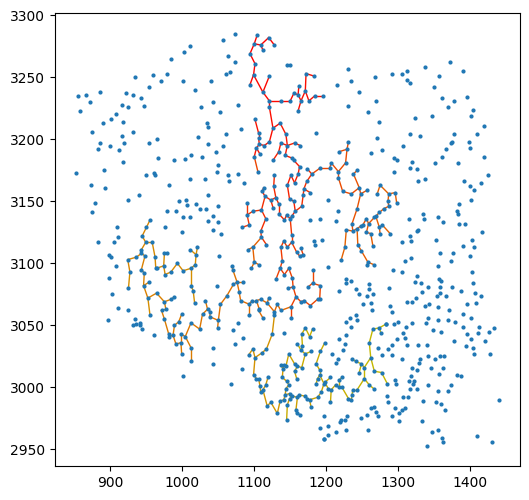

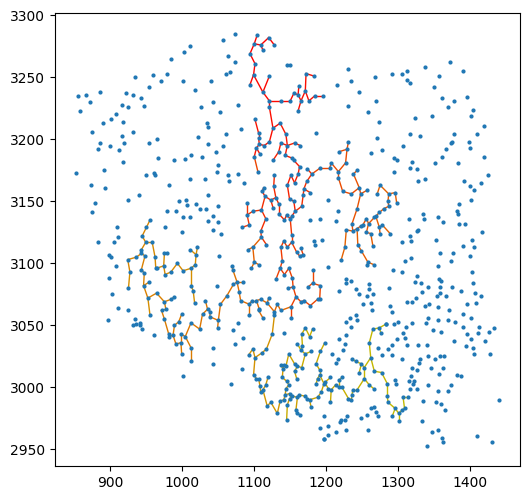

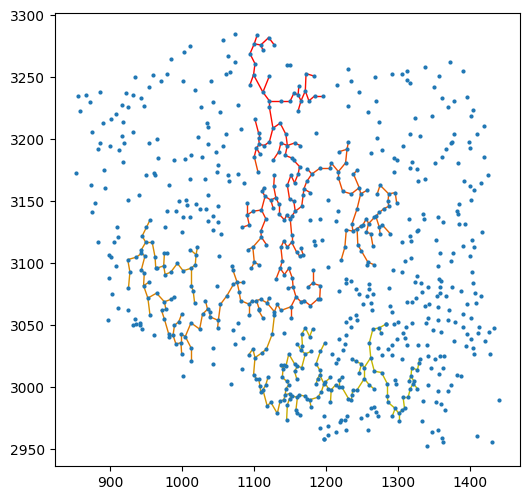

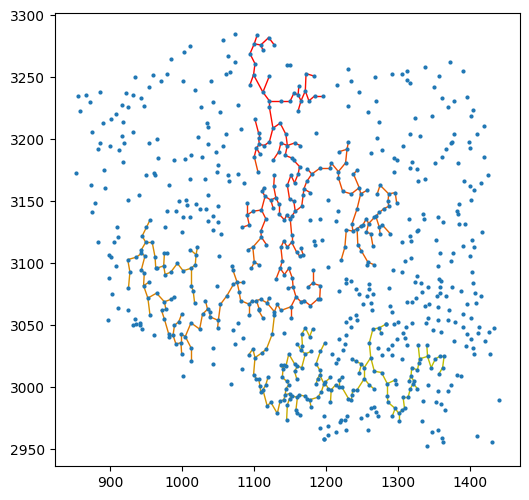

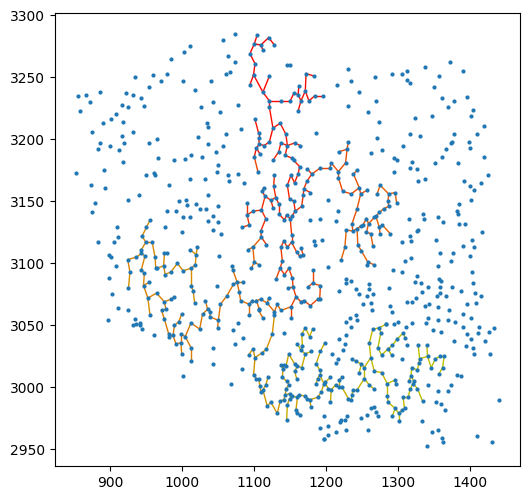

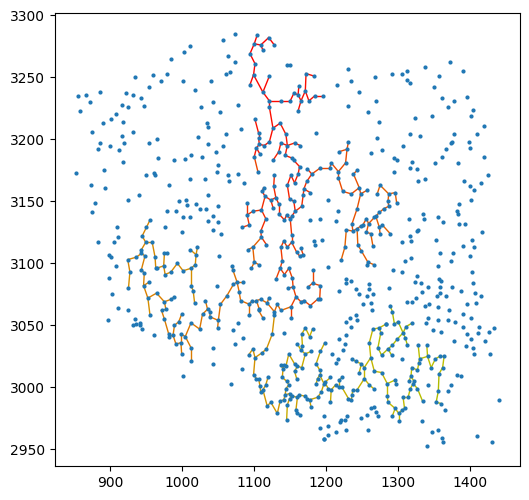

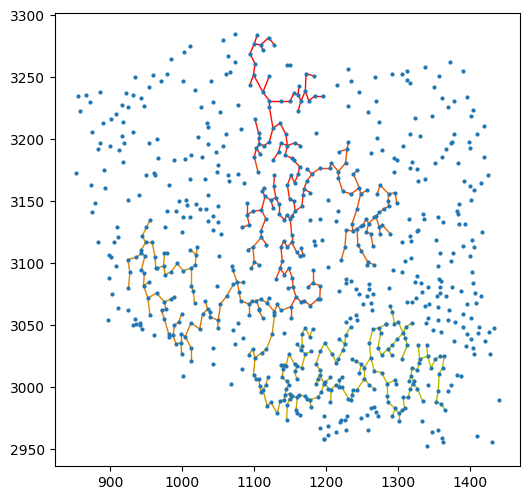

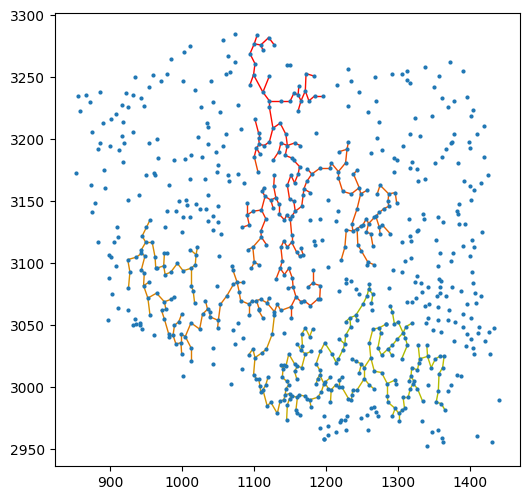

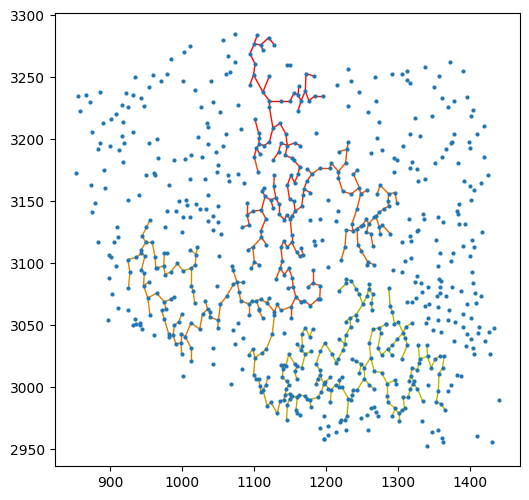

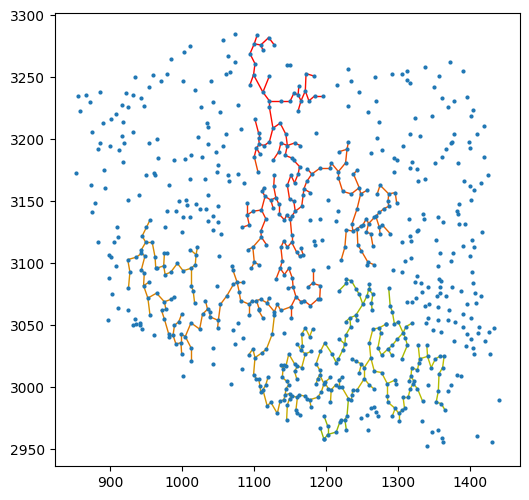

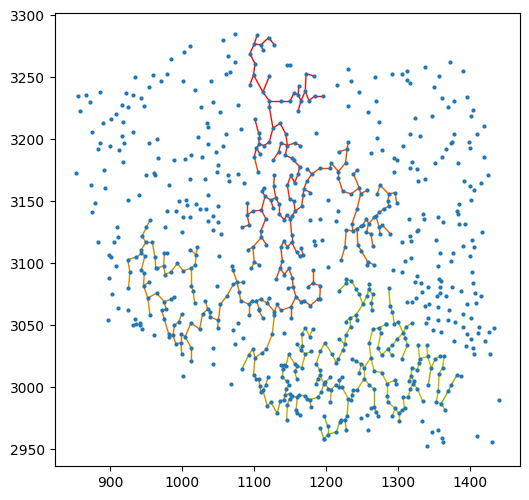

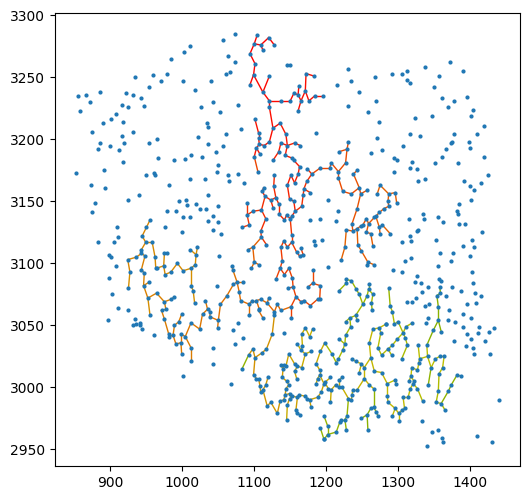

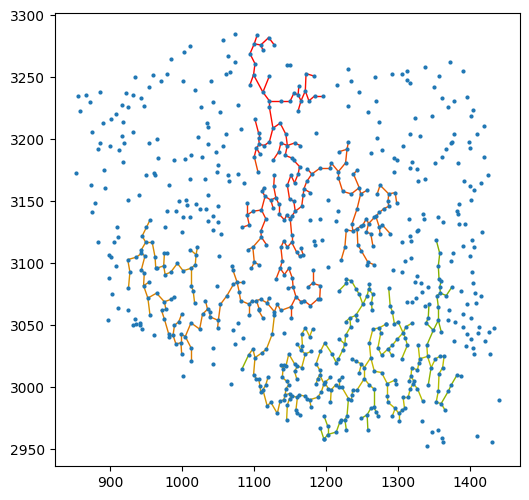

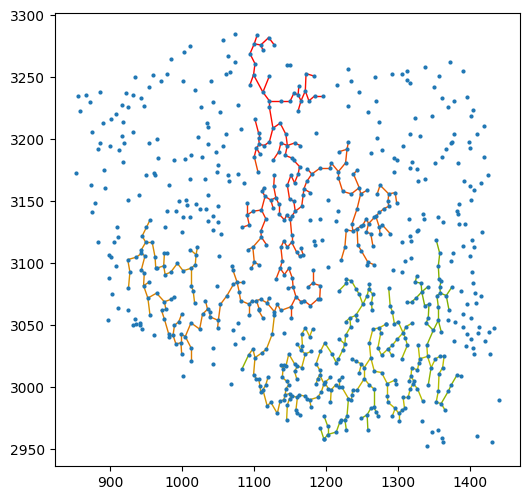

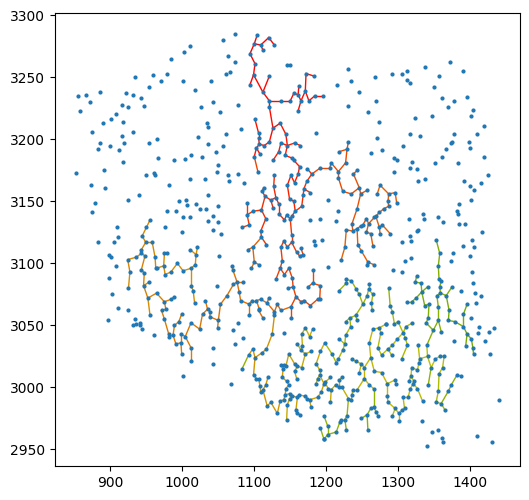

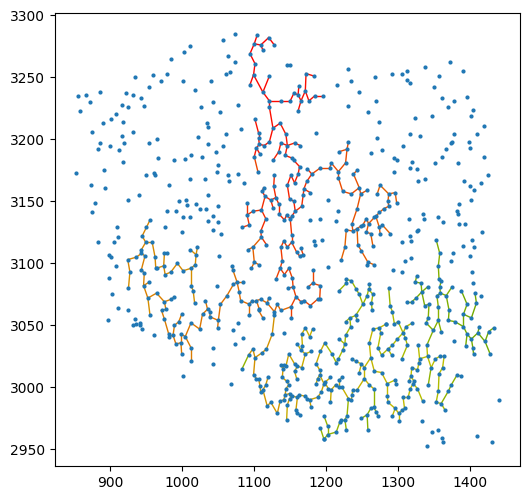

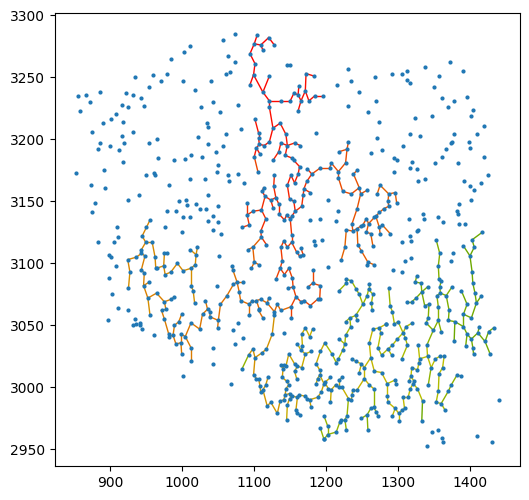

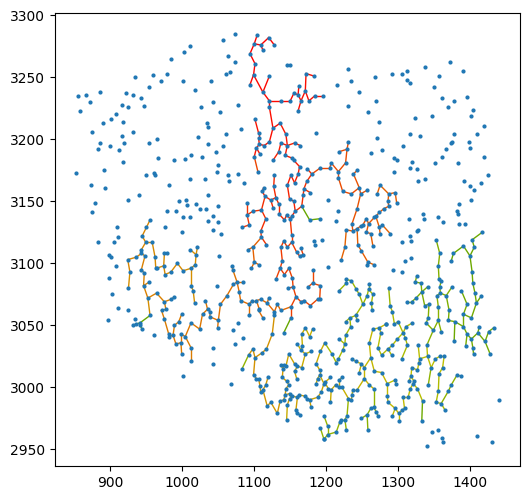

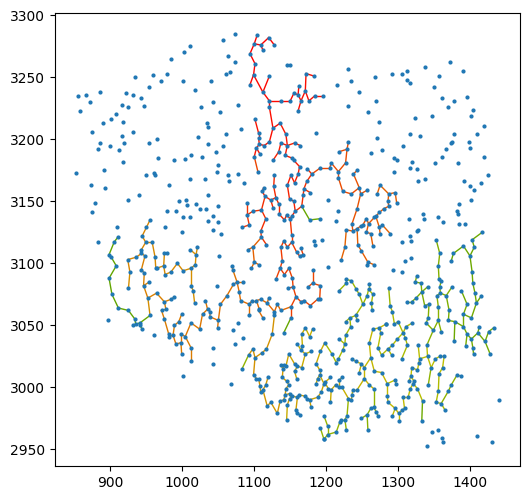

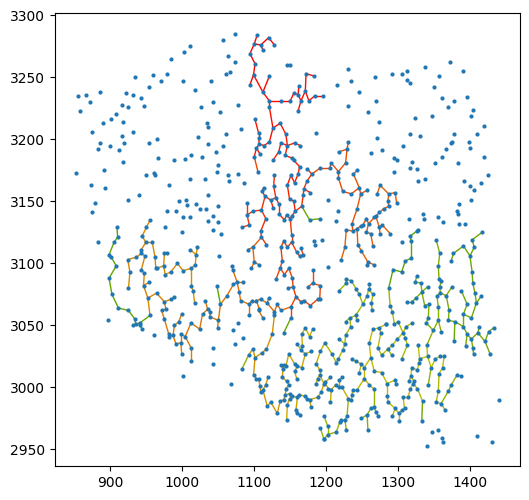

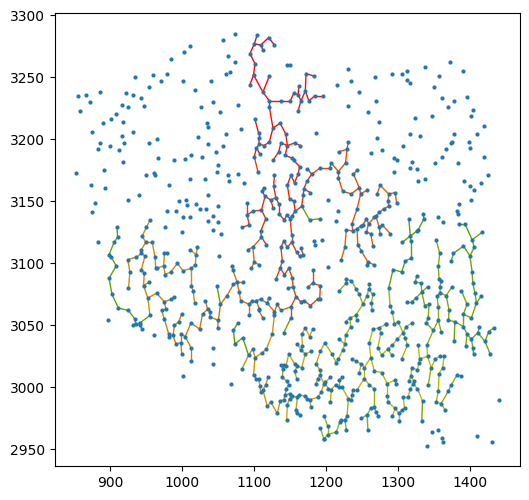

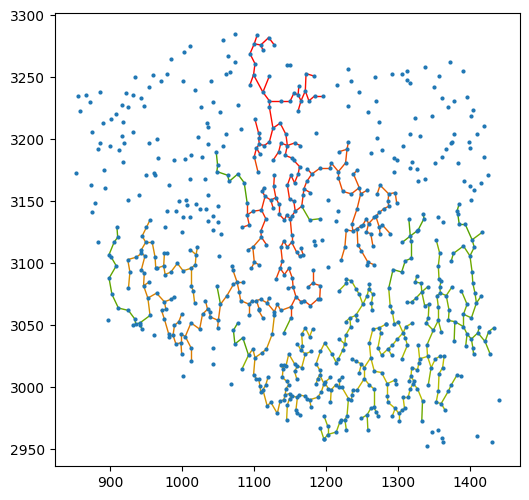

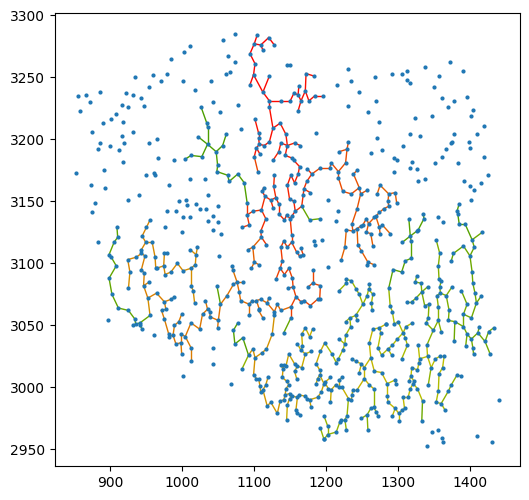

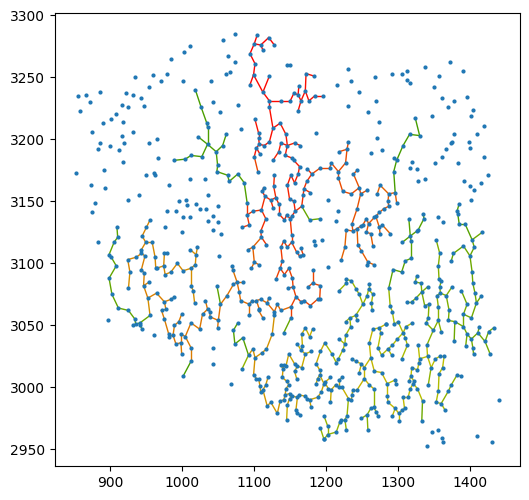

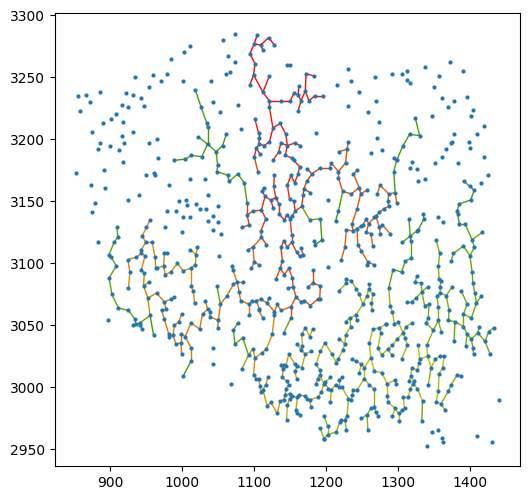

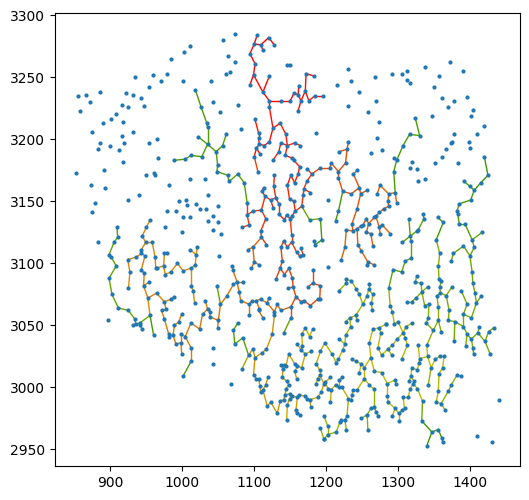

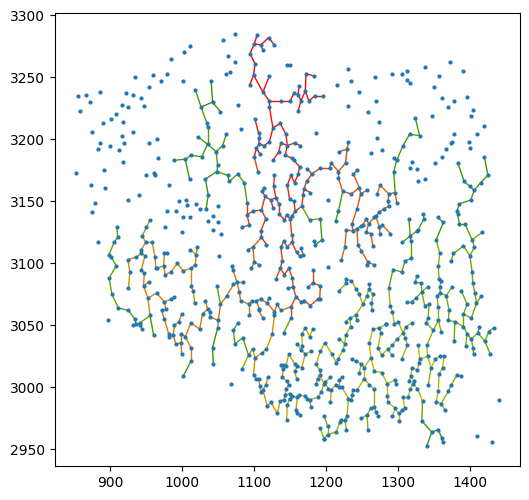

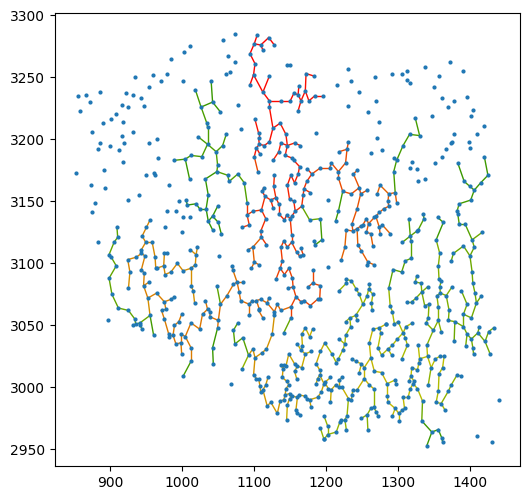

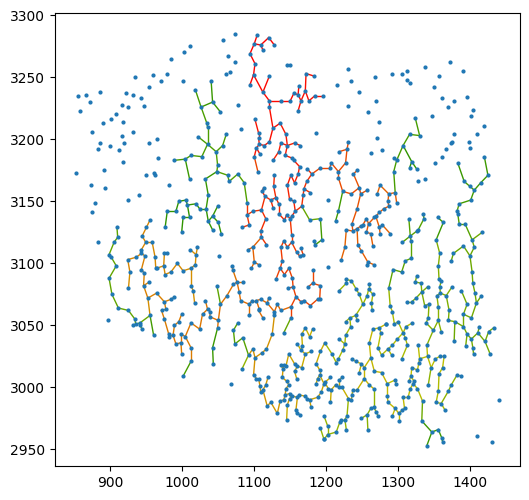

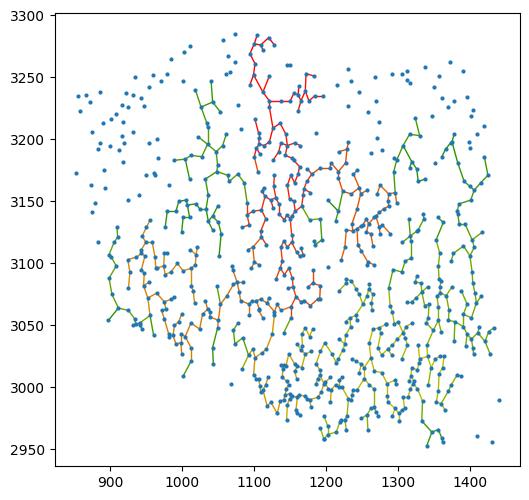

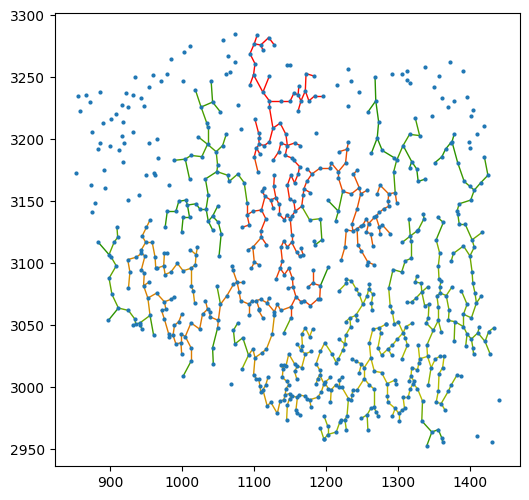

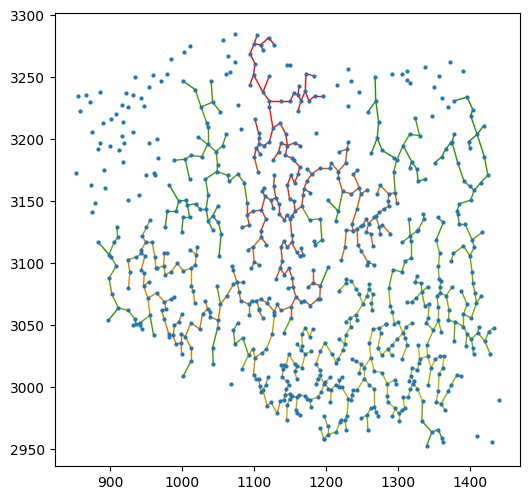

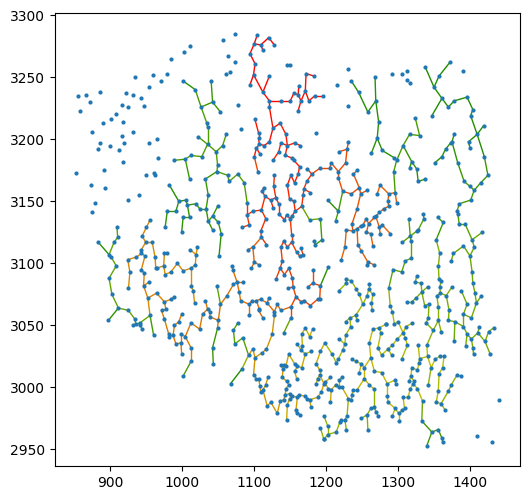

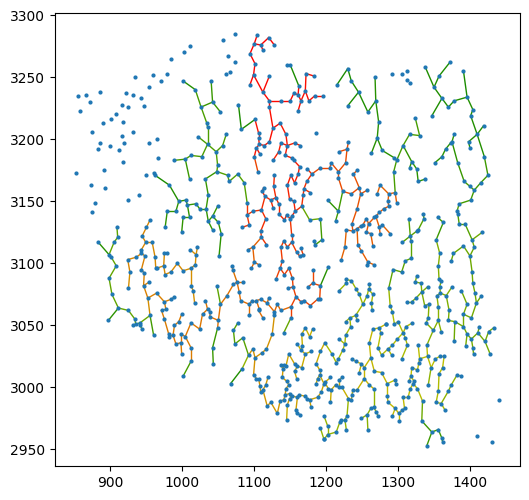

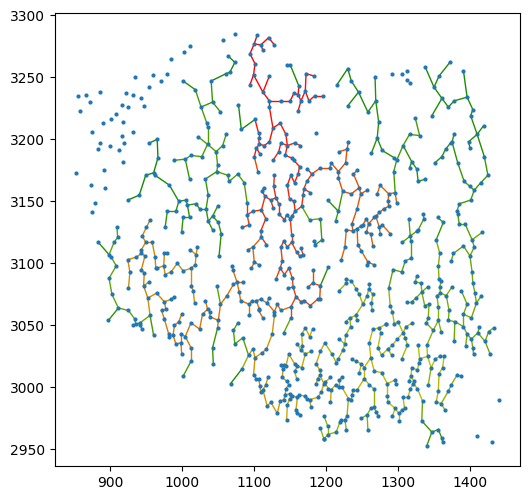

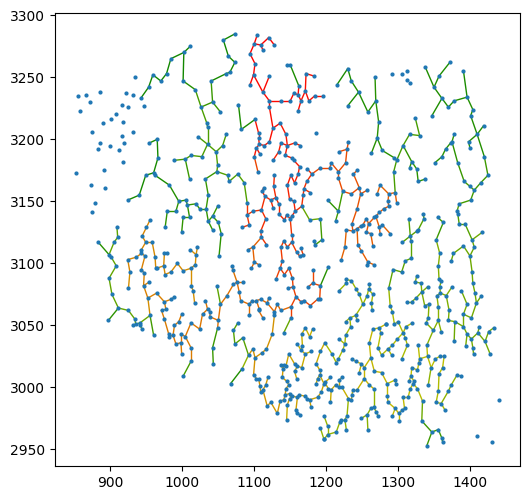

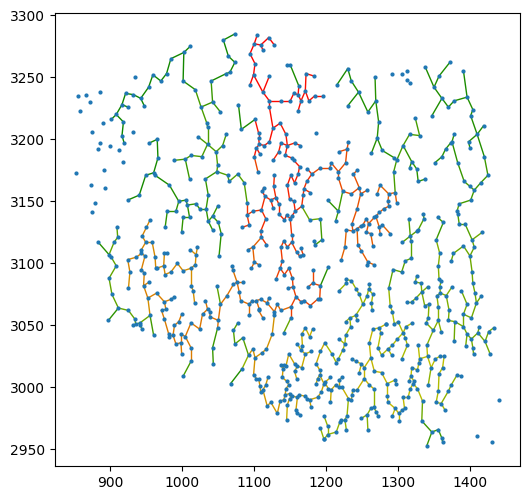

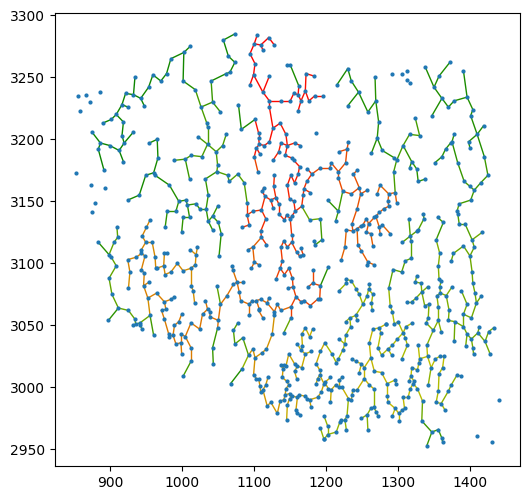

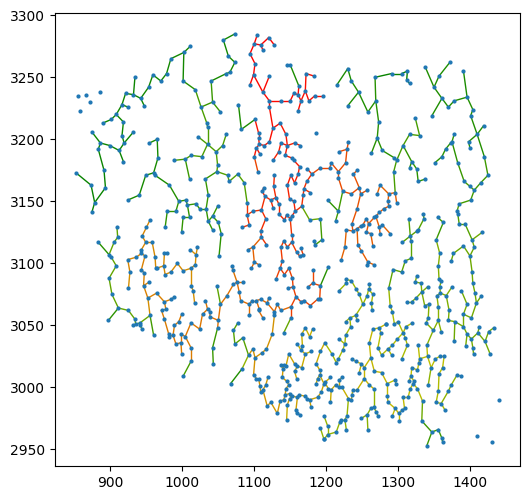

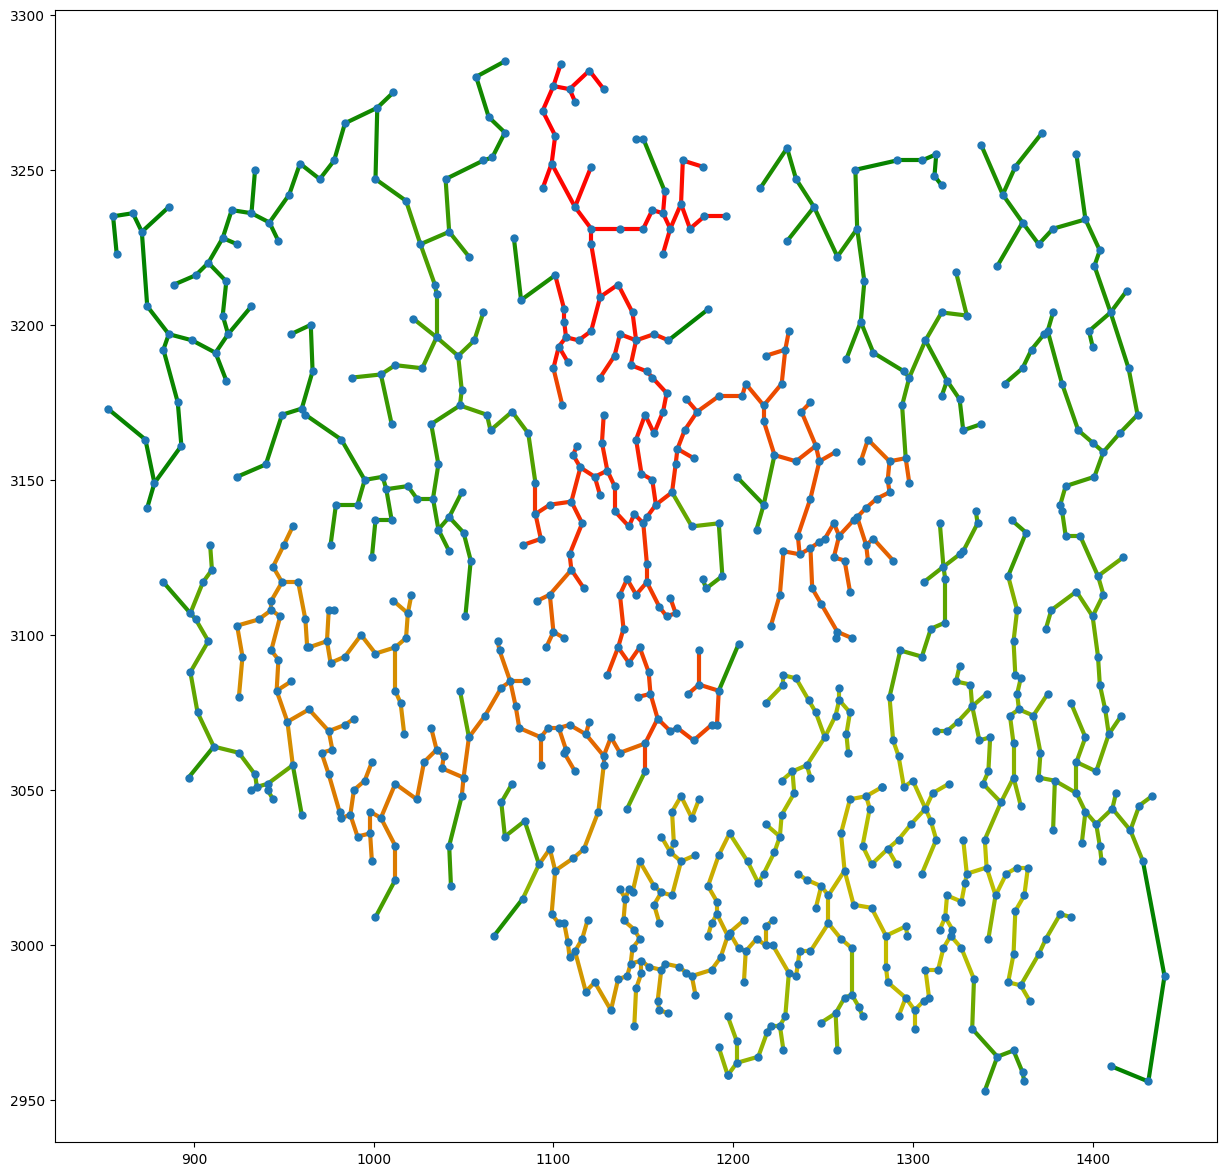

In [9]:
def getSpanningTree(stratingNode, cities, D):
    N = len(cities) 
    edges = []
    IN_TREE = set()
    d = {getIdx(city.name, cities_small): [None, 99999] for city in cities}   # { city: [from city, min_distance] }
    d[stratingNode] = [stratingNode, 0]
    closest_node = sorted(d, key=lambda x: d[x][1])[0]
    
    step = 0
    while len(IN_TREE) < N:
        IN_TREE.add(closest_node)
        edges.append([closest_node, d[closest_node][0]])
        
        for col in D[closest_node]:
            if col[1] < d[col[0]][1]:
                d[col[0]] = [closest_node, col[1]]
        
        for city in sorted(d, key=lambda x: d[x][1]):
            if city not in IN_TREE:
                closest_node = city
                break
                
        step += 1
        if step >= 10:
            plotMap(cities, edges=edges)
            step = 0

    return edges

edges = getSpanningTree(getIdx("Hel", cities_small), cities_small, D)
plotMap(cities_small, edges=edges, size=(15, 15), pointsize=5, lineweight=3)